In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-whitegrid')
import os
import codecs
import gc
import json

DATA_DIR = 'data'
FILE_NAME = 'train.csv'
INPUT_FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)

CHUNKSIZE = 10000
# MAX_ROW_NUM = 50000000
MAX_ROW_NUM = 3000000

In [68]:
# NYC Valid Range Definition
# According to Google Map (for geomatric information, https://www.google.com/maps) 
#              NYC Taxi & Limousine Commission (for rules, http://www.nyc.gov/html/tlc/html/passenger/taxicab_rights.shtml7)
#              and Wikipedia ()
# snapshot a map image on the OpenStreetMap (https://www.openstreetmap.org/relation/175905#map=11/40.6973/-74.0657)
# longitude = -74.3400 -73.6700
# lattitude = 40.9500 40.4500
# scale = 1:419787
# pic 634 x 624
# accroding to the legend, water RGB is 180 206 206
# fare amount min: 
# passenger count: min: 1 max: 5
NYC_RANGE = (-74.3400, -73.6700, 40.4500, 40.9500)
MAP_RESO = (634, 624)
SCALE = 419787
NYC_RANGE_EXTENDED = (-74.4667, -73.0083, 40.4203, 41.3077)
WATER_RGB = (170/255, 211/255, 223/255)

In [30]:
# Get a map image for visualization
# Based on the range
NYC_RANGE_FILENAME = 'realnycmap.png'
nyc_map = plt.imread(os.path.join(DATA_DIR, NYC_RANGE_FILENAME))

NYC_EXTENDED_FILENAME = 'realnycextended.png'
nyc_map_extended = plt.imread(os.path.join(DATA_DIR, NYC_EXTENDED_FILENAME))

In [35]:
def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

df = pd.read_csv(INPUT_FILE_PATH, nrows = MAX_ROW_NUM)
# df['pickup_datetime'] = lookup(df['pickup_datetime'])
# parse date time so slow, use https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,3.000000e+06,3.000000e+06,3.000000e+06,2.999977e+06,2.999977e+06,3.000000e+06
mean,1.134246e+01,-7.250894e+01,3.992033e+01,-7.250740e+01,3.991728e+01,1.684528e+00
std,9.828907e+00,1.320223e+01,8.644440e+00,1.308827e+01,9.984419e+00,1.329084e+00
min,-6.200000e+01,-3.426609e+03,-3.488080e+03,-3.408430e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073492e+01,-7.399139e+01,4.073402e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,2.912465e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [36]:
#Drop missing
df = df.dropna(how = 'any', axis = 'rows')
print ('After Dropping Null: ', len(df))

After Dropping Null:  2999977


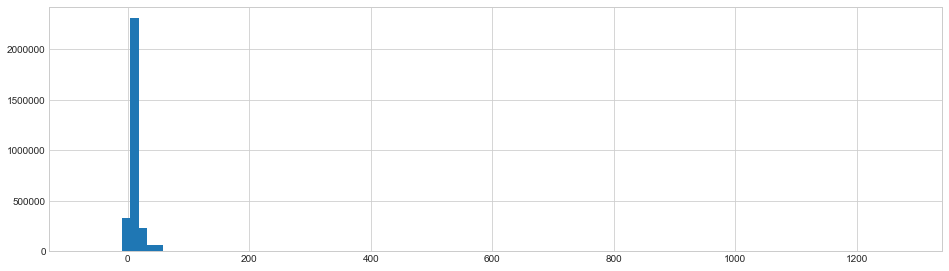

In [13]:
#Plot fare
df.fare_amount.hist(bins=100, figsize=(16, 4.5))

In [37]:
#Drop abnormal fare
def drop_abnormal_fare(df):
    # mind that here is the boolean calculation, & has a higher prior
    return (df.fare_amount>=0) & (df.fare_amount<1000)

df = df[drop_abnormal_fare(df)]
print ('After Dropping Abnormal Fare: ', len(df))

After Dropping Abnormal Fare:  2999852


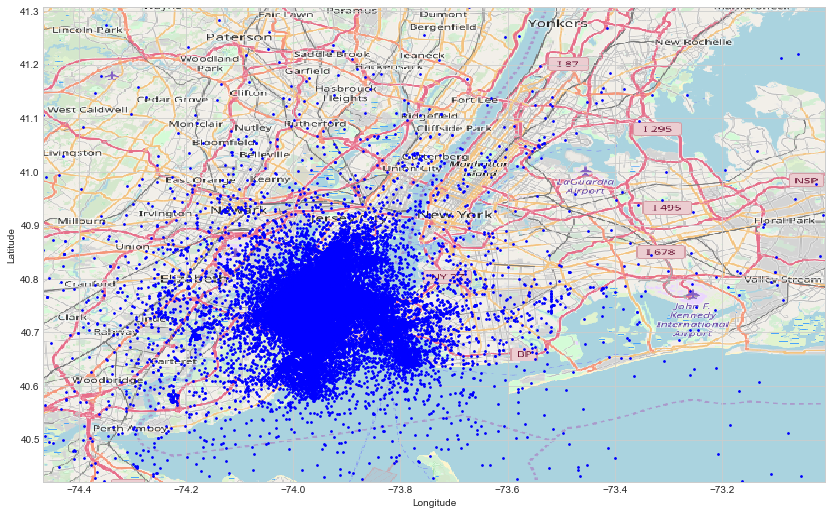

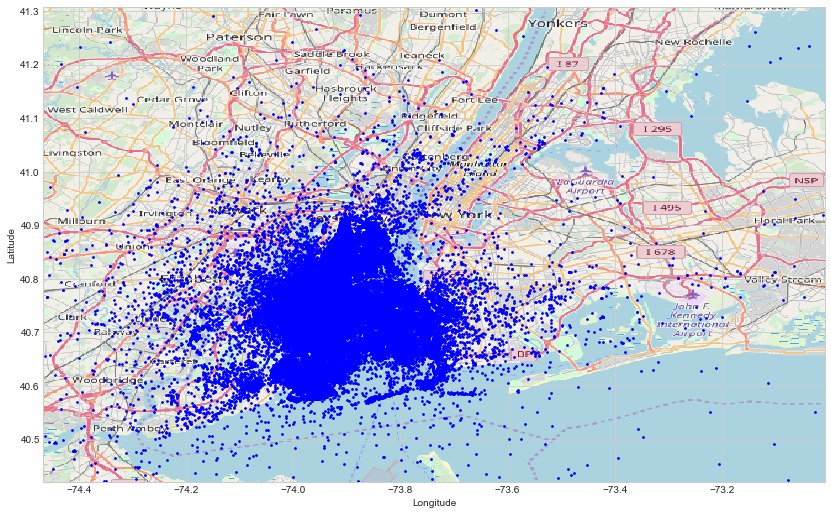

In [39]:
#Plot lon & lat
def plot_lon_lat(lon, lat, geomap=None, box=None):
    plt.figure(figsize=(14, 14))
    plt.scatter(lon, lat, s=3, c='b')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    if geomap is not None:
        plt.xlim(box[0], box[1])
        plt.ylim(box[2], box[3])
        plt.imshow(nyc_map, zorder=0, extent=box)
plot_lon_lat(df.pickup_longitude, df.pickup_latitude, nyc_map_extended, NYC_RANGE_EXTENDED)
plot_lon_lat(df.dropoff_longitude, df.dropoff_latitude, nyc_map_extended, NYC_RANGE_EXTENDED)

In [41]:
# Drop lat&lon in pickup & dropoff
def lon_lat_in_range(df, box):
    return (df.pickup_latitude >= box[2]) & (df.pickup_latitude <= box[3]) & \
           (df.pickup_longitude >= box[0]) & (df.pickup_longitude <= box[1]) & \
           (df.dropoff_latitude >= box[2]) & (df.dropoff_latitude <= box[3]) & \
           (df.dropoff_longitude >= box[0]) & (df.dropoff_longitude <= box[1])

df = df[lon_lat_in_range(df, NYC_RANGE_EXTENDED)]
# plot_lon_lat(df.pickup_longitude, df.pickup_latitude, nyc_map_extended, NYC_RANGE_EXTENDED)
# plot_lon_lat(df.dropoff_longitude, df.dropoff_latitude, nyc_map_extended, NYC_RANGE_EXTENDED)
print ('After Dropping Abnormal Location: ', len(df))

After Dropping Abnormal Location:  2935342


In [75]:
# Drop points in the water
# def drop_points_in_water(df):
#rgba
water_mask = plt.imread(os.path.join(DATA_DIR, NYC_EXTENDED_FILENAME))
#h x w x rgba
# water_mask.shape
# water_mask
water_mask = (water_mask[:,:,0] <= WATER_RGB[0] + 1e-4) & \
             (water_mask[:,:,0] >= WATER_RGB[0] - 1e-4) & \
             (water_mask[:,:,1] <= WATER_RGB[1] + 1e-4) & \
             (water_mask[:,:,1] >= WATER_RGB[1] - 1e-4) & \
             (water_mask[:,:,2] <= WATER_RGB[2] + 1e-4) & \
             (water_mask[:,:,2] >= WATER_RGB[2] - 1e-4) 
water_mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [80]:
def lon_lat_to_pixel(lon, lat, map, box):
    s = map.shape
    return ((s[0] - abs((lat - box[2]) / (box[3] - box[2])) * s[0]).astype('int'),
            (abs((lon - box[0]) / (box[1] - box[0])) * s[1]).astype('int') )
# lon_lat_to_pixel(df.pickup_longitude, df.pickup_latitude, nyc_map_extended, NYC_RANGE_EXTENDED)

def drop_points_in_water(df, map, box):
    pickup_idx = lon_lat_to_pixel(df.pickup_longitude, df.pickup_latitude, 
                                  nyc_map_extended, NYC_RANGE_EXTENDED)
    dropoff_idx = lon_lat_to_pixel(df.dropoff_longitude, df.dropoff_latitude, 
                                   nyc_map_extended, NYC_RANGE_EXTENDED)
    merge_idx = water_mask[pickup_idx] & water_mask[dropoff_idx]
    print ("Points in water:", np.sum(merge_idx))
    return ~merge_idx
# drop_points_in_water(df, nyc_map_extended, NYC_RANGE_EXTENDED)

In [81]:
df = df[drop_points_in_water(df, nyc_map_extended, NYC_RANGE_EXTENDED)]
print ('Points After Dropping in the Water: ', len(df))

Points in water: 700


ValueError: cannot label index with a null key